In [1]:
from agents import agent_loss, CAPM_Agent, MVP_Agent, Uniform_Agent
from trading_env.environment import TradingEnv

import dill
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt

## Recall data

In [2]:
with open('test_data.dill','rb') as dill_file:
    test_data = dill.load(dill_file)
test_dates = test_data['dates']
test_data = test_data['data']

env = TradingEnv(test_data)
n_stocks = env.n_stocks
start = env._start_tick

## Recall trained agent

In [3]:
with open('dpm_agent.dill','rb') as dill_file:
    dpm_agent = dill.load(dill_file)

capm_agent = CAPM_Agent(n_stocks)
mvp_agent = MVP_Agent(n_stocks)
uniform_agent = Uniform_Agent(n_stocks)

### Run a single simulation on all stock data

In [4]:
env = TradingEnv(test_data)

dpm_loss = agent_loss(env,dpm_agent)
dpm_val_hist = env.portfolio_value_hist

capm_loss = agent_loss(env,capm_agent)
capm_val_hist = env.portfolio_value_hist

mvp_loss = agent_loss(env,mvp_agent)
mvp_val_hist = env.portfolio_value_hist

uniform_loss = agent_loss(env,uniform_agent)
uniform_val_hist = env.portfolio_value_hist


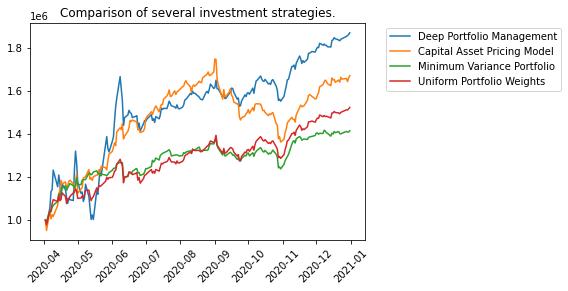

In [5]:
plt.plot(test_dates[start:],dpm_val_hist,label='Deep Portfolio Management')
plt.plot(test_dates[start:],capm_val_hist,label='Capital Asset Pricing Model')
plt.plot(test_dates[start:],mvp_val_hist,label='Minimum Variance Portfolio')
plt.plot(test_dates[start:],uniform_val_hist,label='Uniform Portfolio Weights')
plt.xticks(rotation=45)
plt.legend(loc='upper right',bbox_to_anchor=(1.6, 1) )
plt.title('Comparison of several investment strategies.')
plt.show()

## Statistical analysis

One simulation is interesting to view but it is important to compare the statistical performance of the agents. Here we will simulate several trials and perform a simple t-test on the results to compare agents. Note the randomization is in the subset of stocks chosen in each trial. On each trial we select with replacement a configuration of 10 out of 36 stocks on which to run simulations. There is a total of ${36 \choose 10} \approx 2.5 \times 10^{8}$ possible configurations. On each trial the configuration is fed into each agent, thus yielding a paired t-test experiment design.

In [6]:
TRIALS = 100
n_trialsize = 10

final_vals = {'DeepPortfolio':[],
              'CAPM':[],
              'MVP':[],
              'Uniform':[]}


capm_agent = CAPM_Agent(n_trialsize)
mvp_agent = MVP_Agent(n_trialsize)
uniform_agent = Uniform_Agent(n_trialsize)

for _ in range(TRIALS):

    sample_idx = random.sample(list(range(n_stocks)),n_trialsize)
    sample = test_data[sample_idx,:,:]

    env = TradingEnv(sample)


    dpm_loss = agent_loss(env,dpm_agent)
    final_vals['DeepPortfolio'].append(env.portfolio_value_hist[-1])

    capm_loss = agent_loss(env,capm_agent)
    final_vals['CAPM'].append(env.portfolio_value_hist[-1])

    mvp_loss = agent_loss(env,mvp_agent)
    final_vals['MVP'].append(env.portfolio_value_hist[-1])

    uniform_loss = agent_loss(env,uniform_agent)
    final_vals['Uniform'].append(env.portfolio_value_hist[-1])

## Visualize the results

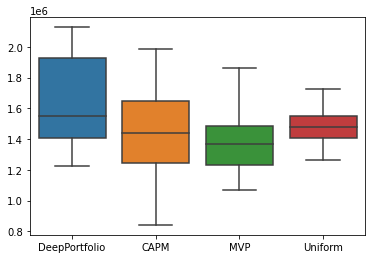

In [7]:
final_vals_df = pd.DataFrame(final_vals).astype(float)

sns.boxplot(data=final_vals_df)
plt.show()


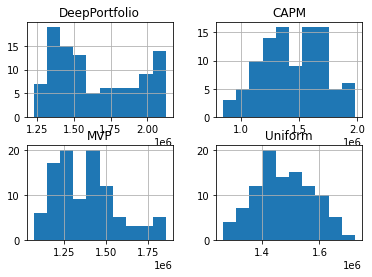

In [8]:
final_vals_df.hist()
plt.show()

## t-test

It seems from the above visualizations that the DeepPortfolio agent outperforms the Uniform agent. The Uniform agent seems to do better than the CAPM agent, but can we be sure about that?

We perform 2 t-tests with the alternative hypotheses that DeepPortfolio outperforms the Uniform portfolio and that Uniform outperforms the CAPM agent.

In [9]:
stats.ttest_rel(final_vals_df['DeepPortfolio'],final_vals_df['Uniform'] ,alternative = 'greater')

Ttest_relResult(statistic=7.497040901954003, pvalue=1.4102879521308646e-11)

In [10]:
stats.ttest_rel(final_vals_df['Uniform'],final_vals_df['CAPM'],alternative='greater')

Ttest_relResult(statistic=1.3773537542518415, pvalue=0.08575449645369529)

The p value for DeepPortfolio vs Uniform is very small, so we can easily reject the null hypothesis an conclude DeepPortfolio outperforms the Uniform agent.

On the other hand the p value for Uniform vs CAPM is only 0.086, thus we do not reject the null hypothesis at the $\alpha = 0.05$ level.
